In [13]:
import os
import numpy as np
from scipy.stats import skew, kurtosis
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix, classification_report,
    ConfusionMatrixDisplay
)
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import shap
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from scipy.stats import skew, kurtosis
import joblib

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
drive_path = "/content/drive/MyDrive/FileStore/"
preprocessed_folder = drive_path + "preprocessed_eeg/"
shap_img = drive_path + "shap_img/"
model_path = drive_path + 'models/'

In [16]:

# Create folder if it doesn't exist
os.makedirs(shap_img, exist_ok=True)
os.makedirs(model_path, exist_ok=True)
use_feature_extraction = False  # ✅ True = extract features, False = flatten raw EEG

X_list, y_list = [], []

for file_name in sorted(os.listdir(preprocessed_folder)):
    if file_name.endswith(".npy") and not file_name.endswith("_label.npy"):
        label_file = file_name.replace(".npy", "_label.npy")
        label_path = os.path.join(preprocessed_folder, label_file)

#         # Only include files with subject ID from 1 to 81
#         if subject_id < 1 or subject_id > 81:
#             continue

        if os.path.exists(label_path):
            X = np.load(os.path.join(preprocessed_folder, file_name))
            y = np.load(label_path)
            X_list.append(X)
            y_list.append(y)
        else:
            print(f"⚠️ Missing label for: {file_name}, skipping.")


X_all = np.concatenate(X_list, axis=0)
y_all = np.concatenate(y_list, axis=0)
print(f"✅ Loaded EEG: {X_all.shape}, Labels: {y_all.shape}")

# ✨ Feature Extraction OR Flattening
if use_feature_extraction:
    print("🔍 Using extracted statistical features...")
    def extract_features(eeg_trial):
        features = []
        for ch in eeg_trial:
            features.extend([
                np.mean(ch), np.std(ch), np.min(ch), np.max(ch),
                skew(ch), kurtosis(ch)
            ])
        return features
    X_feat = np.array([extract_features(trial) for trial in X_all])
else:
    print("📉 Using flattened raw EEG signals...")
    X_feat = X_all.reshape(X_all.shape[0], -1)

print(f"✅ Feature shape: {X_feat.shape}")

if not use_feature_extraction:
    channel_names = ['Fz', 'FCz', 'Cz', 'CPz', 'Pz']
    n_channels = len(channel_names)
    n_timepoints = X_all.shape[2]  # e.g., 250

    feature_names = [f"{ch}_t{t}" for ch in channel_names for t in range(n_timepoints)]
else:
    # fallback if you're using extracted features
    feature_names = [f"feat_{i}" for i in range(X_feat.shape[1])]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_feat, y_all, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# selector = SelectKBest(score_func=f_classif, k=400)
# X_train_selected = selector.fit_transform(X_train_scaled, y_train)
# X_test_selected = selector.transform(X_test_scaled)


# selected_feature_names = np.array(feature_names)[selector.get_support()]


✅ Loaded EEG: (33191, 5, 250), Labels: (33191,)
📉 Using flattened raw EEG signals...
✅ Feature shape: (33191, 1250)


In [17]:
svm_model = joblib.load(os.path.join(model_path, "svm_model.joblib"))
rf_model = joblib.load(os.path.join(model_path, "rf_model.joblib"))
lr_model = joblib.load(os.path.join(model_path, "lr_model.joblib"))



🔍 Evaluating SVM...
📊 Classification Metrics
Accuracy: 0.7731586082241302
Precision: 0.7847305389221557
Recall: 0.7690727699530516
F1 Score: 0.7768227622999407
AUC: 0.8609495490429422
Specificity: 0.7774682760755184
False Positive Rate: 0.2225317239244816
Error Rate: 0.22684139177586987


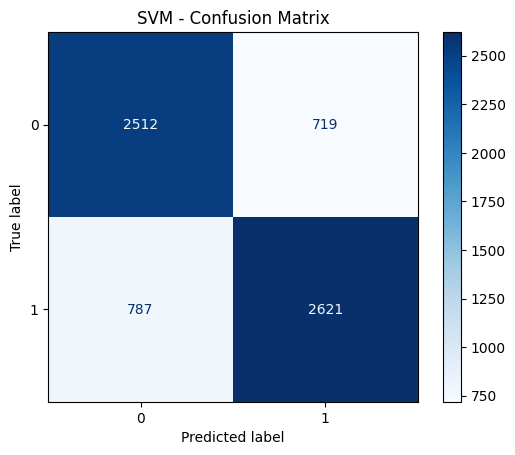

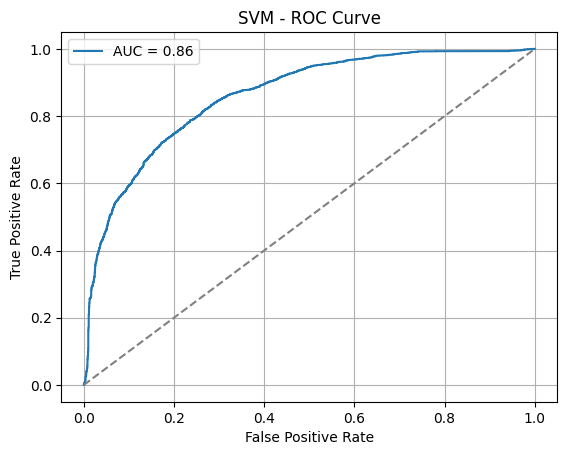

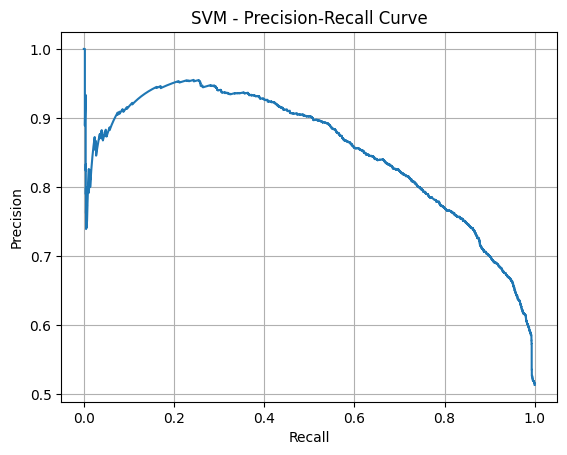

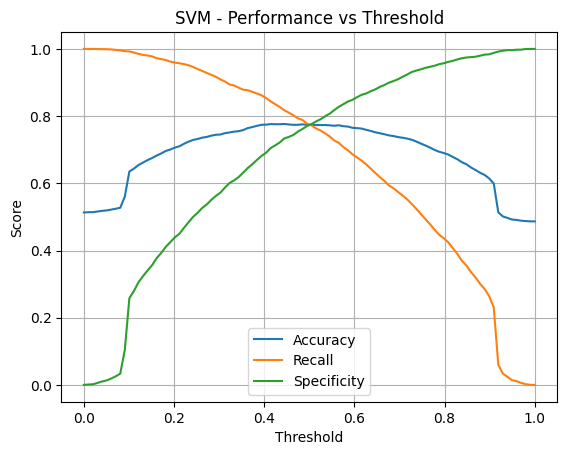


🔍 Evaluating Random Forest...
📊 Classification Metrics
Accuracy: 0.9255912034945022
Precision: 0.9233004067402673
Recall: 0.9325117370892019
F1 Score: 0.9278832116788321
AUC: 0.9857176498068158
Specificity: 0.9182915506035283
False Positive Rate: 0.08170844939647168
Error Rate: 0.07440879650549781


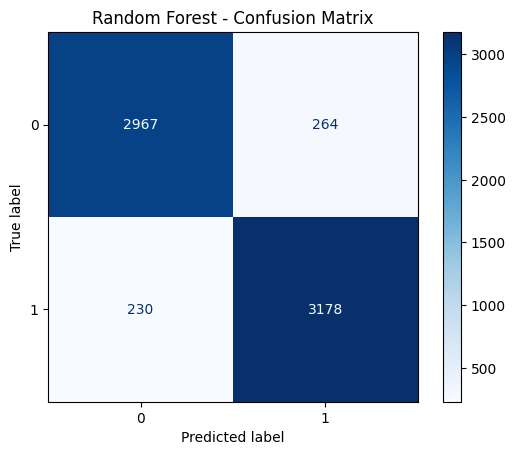

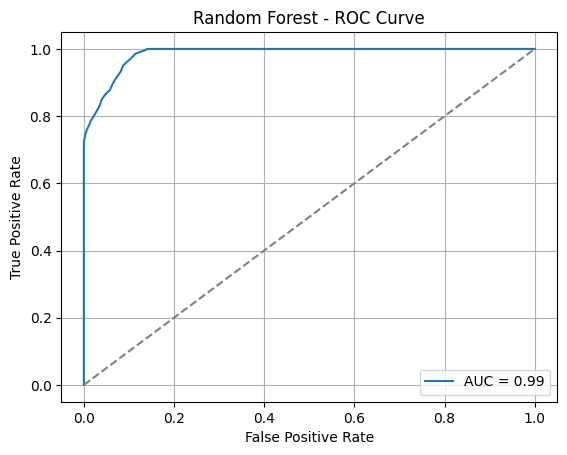

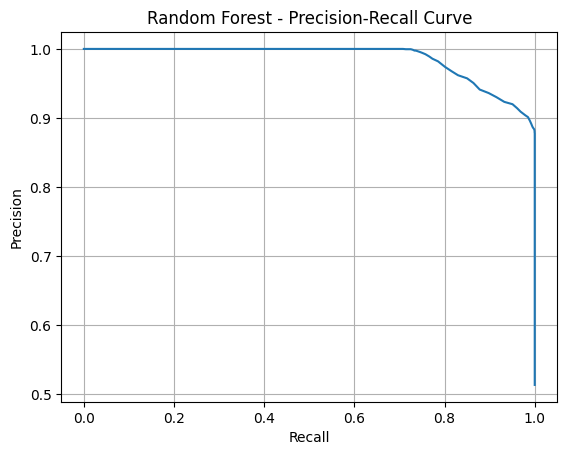

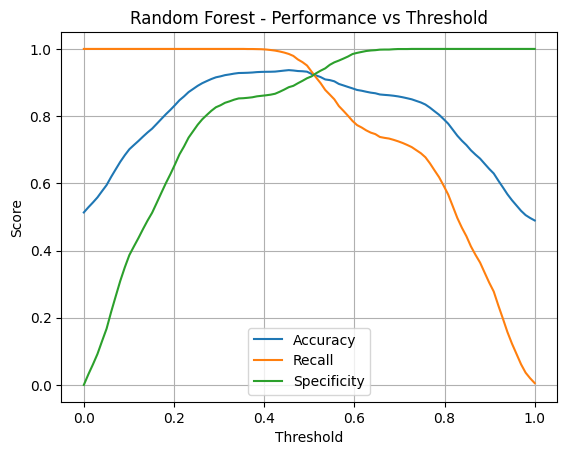


🔍 Evaluating Logistic Regression...
📊 Classification Metrics
Accuracy: 0.4083446302153939
Precision: 0.4307405434203516
Recall: 0.4744718309859155
F1 Score: 0.4515498464116169
AUC: 0.3658816875253377
Specificity: 0.3385948622717425
False Positive Rate: 0.6614051377282575
Error Rate: 0.5916553697846061


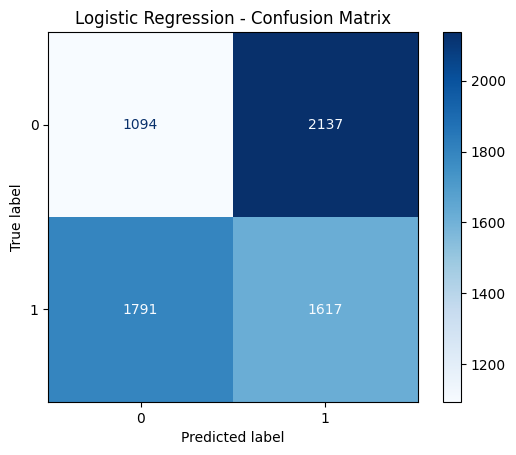

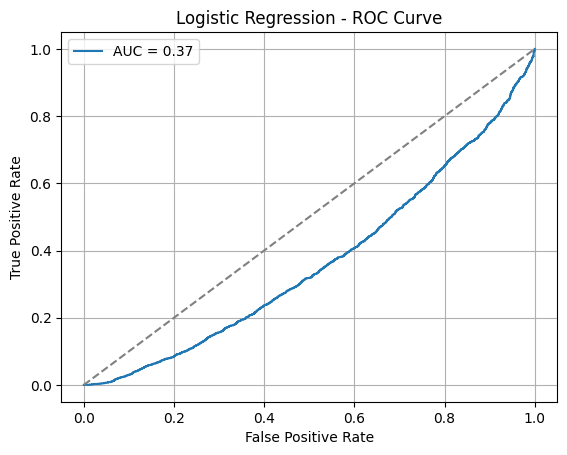

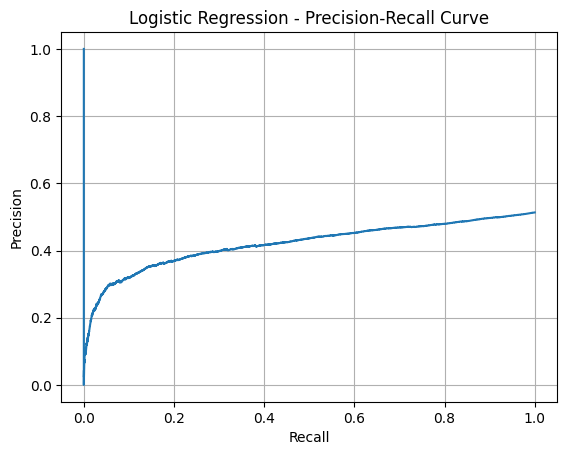

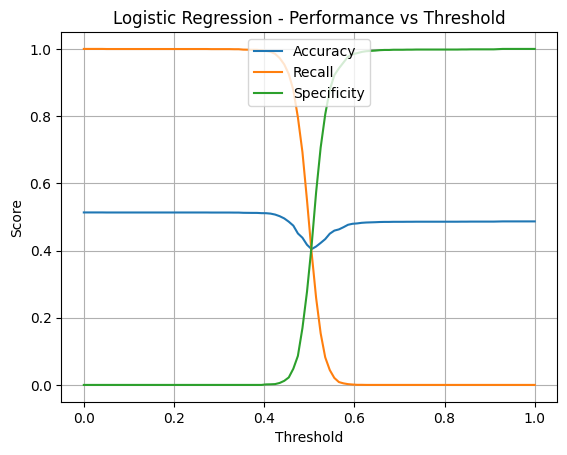

In [19]:
models = {
    "SVM": svm_model,
    "Random Forest": rf_model,
    "Logistic Regression": lr_model
}

for model_name, model in models.items():
    print(f"\n🔍 Evaluating {model_name}...")

    y_pred = model.predict(X_test_scaled)

    if hasattr(model, "predict_proba"):
        y_pred_probs = model.predict_proba(X_test_scaled)[:, 1]
    elif hasattr(model, "decision_function"):
        # For SVM without `predict_proba`
        y_pred_probs = model.decision_function(X_test_scaled)
        y_pred_probs = (y_pred_probs - y_pred_probs.min()) / (y_pred_probs.max() - y_pred_probs.min())  # normalize to [0, 1]
    else:
        raise ValueError(f"{model_name} does not support probability prediction.")

    # Basic metrics
    print("📊 Classification Metrics")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))

    auc_score = roc_auc_score(y_test, y_pred_probs)
    print("AUC:", auc_score)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn + fp)
    fpr = fp / (fp + tn)
    error_rate = (fp + fn) / (tp + tn + fp + fn)
    print("Specificity:", specificity)
    print("False Positive Rate:", fpr)
    print("Error Rate:", error_rate)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f"{model_name} - Confusion Matrix")
    plt.show()

    # ROC Curve
    fpr_vals, tpr_vals, _ = roc_curve(y_test, y_pred_probs)
    plt.figure()
    plt.plot(fpr_vals, tpr_vals, label=f'AUC = {auc_score:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} - ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_probs)
    plt.figure()
    plt.plot(recall, precision)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{model_name} - Precision-Recall Curve')
    plt.grid(True)
    plt.show()

    # Performance vs Threshold
    thresholds = np.linspace(0, 1, 100)
    accuracies, recalls, specificities = [], [], []

    for thresh in thresholds:
        pred_thresh = (y_pred_probs >= thresh).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_test, pred_thresh).ravel()
        acc = (tp + tn) / (tp + tn + fp + fn)
        rec = tp / (tp + fn) if (tp + fn) > 0 else 0
        spec = tn / (tn + fp) if (tn + fp) > 0 else 0
        accuracies.append(acc)
        recalls.append(rec)
        specificities.append(spec)

    plt.figure()
    plt.plot(thresholds, accuracies, label='Accuracy')
    plt.plot(thresholds, recalls, label='Recall')
    plt.plot(thresholds, specificities, label='Specificity')
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title(f"{model_name} - Performance vs Threshold")
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
def explain_with_shap(model, model_name, X_train, X_test, feature_names=None, is_tree_model=False):
    import shap
    import numpy as np
    import matplotlib.pyplot as plt

    print(f"\n📊 Explaining {model_name} with SHAP...")

    # ----------- Create explainer and compute shap_values ----------- #
    if is_tree_model:
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_test)
        sample = X_test
    else:
        print("⚠️ KernelExplainer is slow. Using 1 test sample and 50 training background points.")
        explainer = shap.KernelExplainer(model.predict_proba, X_train[:50])
        shap_values = explainer.shap_values(X_test[:1])
        sample = X_test[:1]

    # ----------- Handle format (list vs array) ----------- #
    if isinstance(shap_values, list):
        shap_to_plot = shap_values[1]  # Class 1
    else:
        shap_to_plot = shap_values     # Already a 2D array

    # ----------- Warn if SHAP values are all zero ----------- #
    if np.allclose(shap_to_plot, 0):
        print("⚠️ Warning: All SHAP values are zero — the model might not be confident for this sample.")
        return

    # ----------- Plot SHAP summary ----------- #
    shap.summary_plot(shap_to_plot, sample, feature_names=feature_names)
    plt.title(f"{model_name} SHAP Summary")
    plt.tight_layout()
    plt.show()

    # ----------- Show Top 10 Features in Console ----------- #
    print("\n🔥 Top 10 Most Important Features:")
    shap_array = np.abs(shap_to_plot).mean(axis=0)
    top_idx = np.argsort(shap_array)[-10:][::-1].tolist()

    for i in top_idx:
        fname = feature_names[i] if feature_names is not None else f"f{i}"
        importance = float(shap_array[i])  # ✅ force to scalar float
        print(f"{str(fname):<15} → SHAP importance: {importance:.6f}")





📊 Explaining SVM with SHAP...
⚠️ KernelExplainer is slow. Using 1 test sample and 50 training background points.


  0%|          | 0/1 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

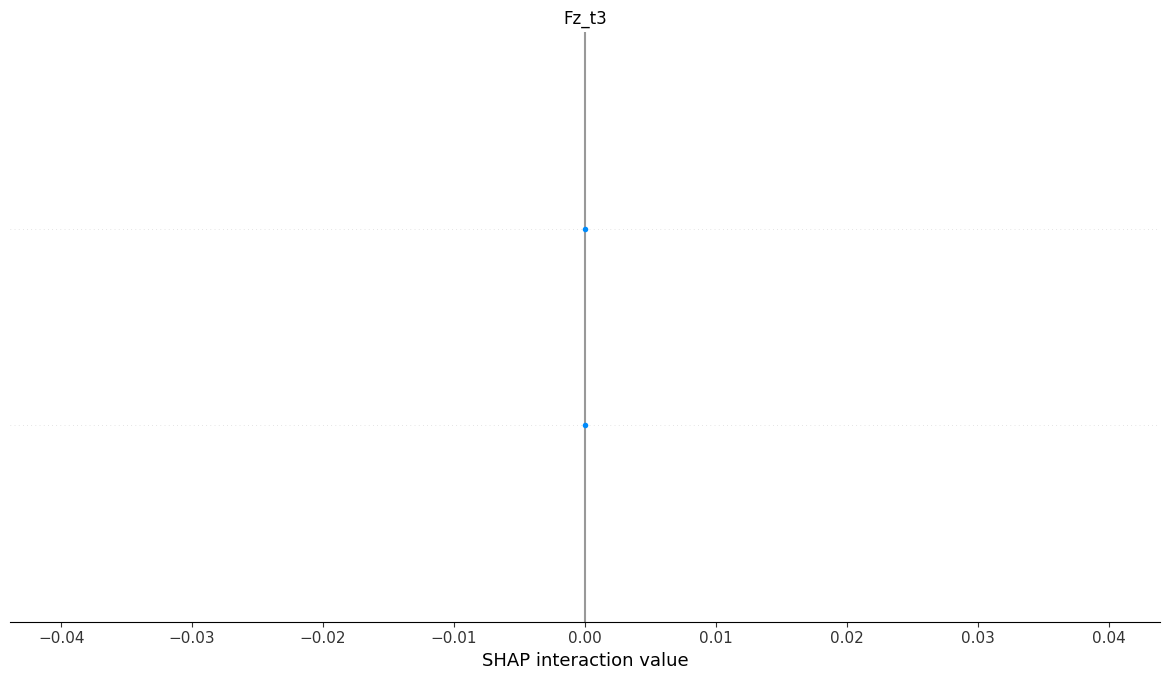

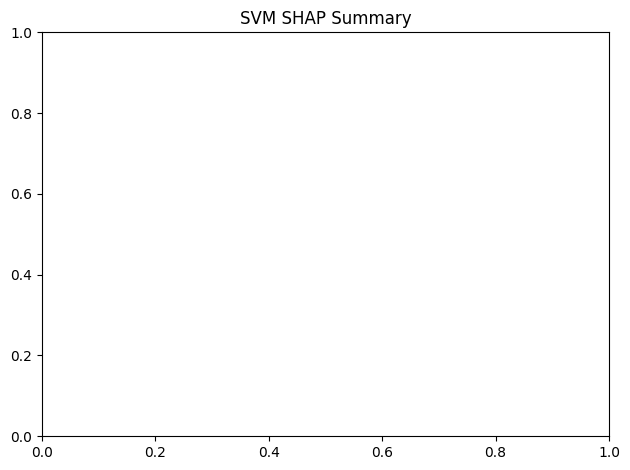


🔥 Top 10 Most Important Features:


TypeError: only length-1 arrays can be converted to Python scalars

In [ ]:
# SVM (non-tree, kernel)
explain_with_shap(
    model=svm_model,
    model_name="SVM",
    X_train=X_train_scaled,
    X_test=X_test_scaled,
    feature_names=selected_feature_names,
    is_tree_model=False
)

# Logistic Regression
explain_with_shap(
    model=lr_model,
    model_name="Logistic Regression",
    X_train=X_train_scaled,
    X_test=X_test_scaled,
    feature_names=selected_feature_names,
    is_tree_model=False
)

# Random Forest
explain_with_shap(
    model=rf_model,
    model_name="Random Forest",
    X_train=X_train_scaled,
    X_test=X_test_scaled,
    feature_names=selected_feature_names,
    is_tree_model=True
)